In [4]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from cvxopt import spmatrix, matrix, solvers
from typing import NoReturn, Callable
from sklearn.datasets import make_classification, make_moons, make_blobs

solvers.options['show_progress'] = False

In [5]:
def visualize(clf, X, y):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_border = (x_max - x_min) / 20 + 1.0e-3
    x_h = (x_max - x_min + 2 * x_border) / 200
    y_border = (y_max - y_min) / 20 + 1.0e-3
    y_h = (y_max - y_min + 2 * y_border) / 200
    
    cm = plt.cm.Spectral

    xx, yy = np.meshgrid(np.arange(x_min - x_border, x_max + x_border, x_h), np.arange(y_min - y_border, y_max + y_border, y_h))
    mesh = np.c_[xx.ravel(), yy.ravel()]

    z_class = clf.predict(mesh).reshape(xx.shape)

    # Put the result into a color plot
    plt.figure(1, figsize=(8, 8))
    plt.pcolormesh(xx, yy, z_class, cmap=cm, alpha=0.3, shading='gouraud')

    # Plot hyperplane and margin
    z_dist = clf.decision_function(mesh).reshape(xx.shape)
    plt.contour(xx, yy, z_dist, [0.0], colors='black')
    plt.contour(xx, yy, z_dist, [-1.0, 1.0], colors='black', linestyles='dashed')

    # Plot also the training points
    y_pred = clf.predict(X)

    ind_support = []
    ind_correct = []
    ind_incorrect = []
    for i in range(len(y)):
        if i in clf.support:
            ind_support.append(i)
        elif y[i] == y_pred[i]:
            ind_correct.append(i)
        else:
            ind_incorrect.append(i)

    plt.scatter(X[ind_correct, 0], X[ind_correct, 1], c=y[ind_correct], cmap=cm, alpha=1., edgecolor='black', linewidth=.8)
    plt.scatter(X[ind_incorrect, 0], X[ind_incorrect, 1], c=y[ind_incorrect], cmap=cm, alpha=1., marker='*',
               s=50, edgecolor='black', linewidth=.8)
    plt.scatter(X[ind_support, 0], X[ind_support, 1], c=y[ind_support], cmap=cm, alpha=1., edgecolor='yellow', linewidths=1.,
               s=40)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.tight_layout()

In [6]:
def generate_dataset(moons=False):
    if moons:
        X, y = make_moons(1000, noise=0.075, random_state=42)
        return X, 2 * y - 1
    X, y = make_blobs(1000, 2, centers=[[0, 0], [-4, 2], [3.5, -2.0], [3.5, 3.5]], random_state=42)
    y = 2 * (y % 2) - 1
    return X, y

X, y = generate_dataset(True)

# Linear SVM

In [7]:
class LinearSVM:
    def __init__(self, C: float):
        self.C = C
        self.support = None
        self.w = None
        self.b = None
        
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        y = y.reshape(1, -1)
        N, k = X.shape
        
        # matrices
        P = spmatrix(1, range(k), range(k), (k+N+1, k+N+1)) 
        q = matrix(np.vstack((np.zeros((k+1, 1)), self.C * np.ones((N, 1)))))
        h = matrix(np.vstack((np.zeros((N, 1)), -1 * np.ones((N, 1)))))
        
        ### G
        # Up
        Left_Up = np.zeros((N, k+1))
        Right_Up = -np.eye(N)
        Upper = np.concatenate((Left_Up, Right_Up), axis=1)
        # Bottom
        Left_Low_0 = -y.T * X
        Left_Low = np.concatenate((Left_Low_0, -y.T), axis=1)
        Right_Low = -np.eye(N)
        Lower = np.concatenate((Left_Low, Right_Low), axis=1)
        # unit
        G = matrix(np.concatenate((Upper, Lower)))

        # qpsolver: w; b
        sol=solvers.qp(P, q, G, h)
        x = np.array(sol['x'])
        self.w = x[:k]
        self.b = x[k]
        
        # support vectors
        res = y.T * self.decision_function(X)
        ind = np.argwhere(res <= 1.0)
        self.support = ind[:,0]
        
        
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        return X @ self.w - self.b
    
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.sign(self.decision_function(X))

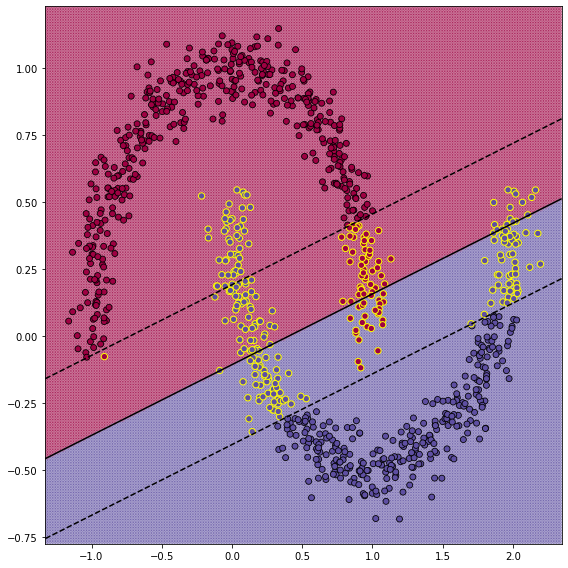

In [9]:
X, y = generate_dataset(True)
svm = LinearSVM(1)
svm.fit(X, y)
visualize(svm, X, y)

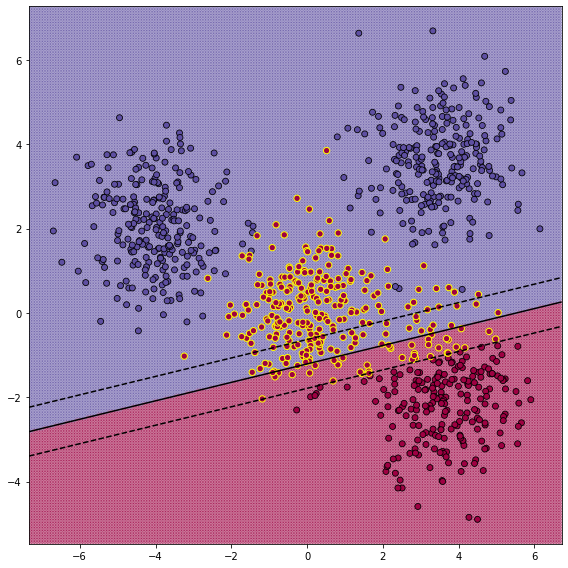

In [8]:
X, y = generate_dataset(False)
svm = LinearSVM(1)
svm.fit(X, y)
visualize(svm, X, y)

# Kernel SVM

In [10]:
def get_polynomial_kernel(c=1, power=2):
    return lambda u, v: (c + u @ v.T) ** power

def get_gaussian_kernel(sigma=1.):
    return lambda u, v: np.exp(-sigma * np.sum((u - v)**2, axis=1))

In [11]:
class KernelSVM:
    def __init__(self, C: float, kernel: Callable = get_polynomial_kernel()):
        self.C = C
        self.kernel = kernel
        self.support = None
        self.a = None
        self.w_0 = None
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        y = y.reshape(1, -1)
        self.X = X
        self.y = y        
        N, k = X.shape
        
        # Matrixes       
        P = matrix(y.T * np.array([self.kernel(X, X[j]) for j in range(N)]) * y)
        q = matrix(-np.ones((N, 1)))
        h = matrix(np.vstack((self.C * np.ones((N, 1)), np.zeros((N, 1)))))
        G = matrix(np.vstack((np.eye(N), -np.eye(N))))
        A = matrix(y, tc='d')
        b = matrix(0.)
            
        # a
        sol=solvers.qp(P, q, G, h, A, b)
        self.a = np.array(sol['x'])
        
        # w_0
        K_ij = np.array([self.kernel(X, X[j]) for j in range(N)]).T
        step_2 = (y * (self.a).T) * K_ij 
        step_3 = np.sum(step_2, axis=1).reshape(-1, 1)
        step_4 = y.T - step_3
        self.w_0 = np.mean(step_4)
        
        # support vectors
        res = y * self.decision_function(X)
        ind = np.argwhere(res <= 1.0)
        self.support = ind[:,1]
        
        
    def decision_function(self, X: np.ndarray) -> np.ndarray:
        N, k = X.shape
        K_ij = np.array([self.kernel(X, self.X[j]) for j in range(self.X.shape[0])]).T    
        step_2 = ((self.a).T * self.y) * K_ij
        return np.sum(step_2, axis=1) + self.w_0
        
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.sign(self.decision_function(X))

# Polynomial kernel

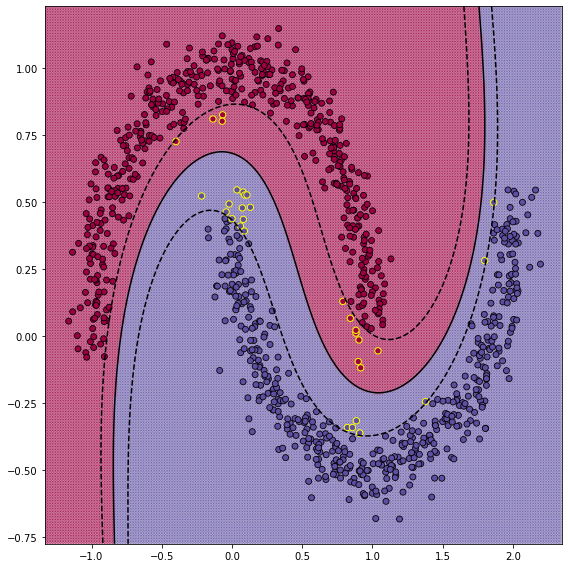

Wall time: 10.2 s


In [12]:
%%time
X, y = generate_dataset(True)
svm = KernelSVM(1, kernel=get_polynomial_kernel(1, 3))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

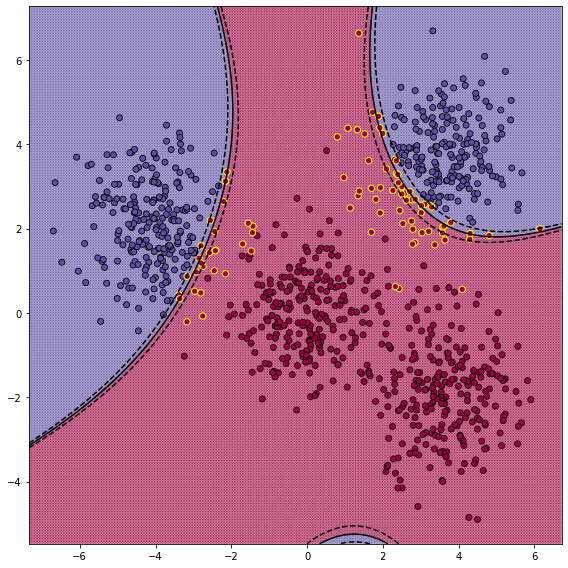

Wall time: 11.9 s


In [13]:
%%time
X, y = generate_dataset(False)
svm = KernelSVM(1, kernel=get_polynomial_kernel(1, 3))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

# Gaussian kernel

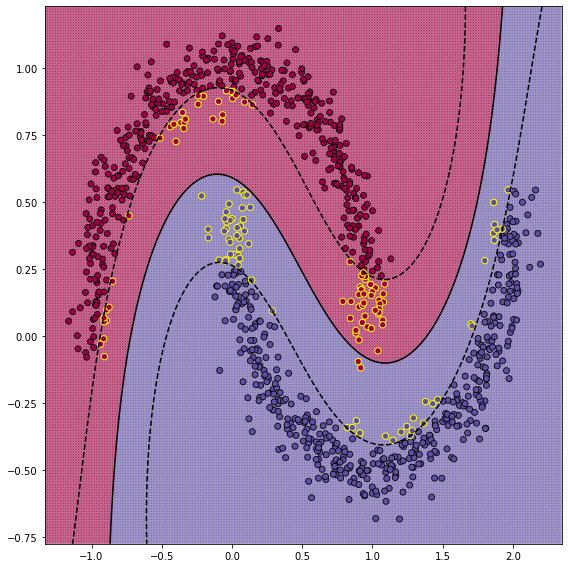

Wall time: 7.65 s


In [14]:
%%time
X, y = generate_dataset(True)
svm = KernelSVM(1, kernel=get_gaussian_kernel(0.4))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

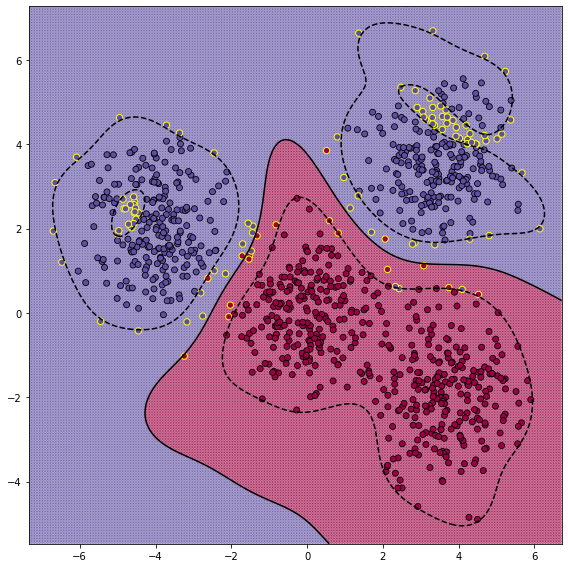

Wall time: 8.08 s


In [15]:
%%time
X, y = generate_dataset(False)
svm = KernelSVM(1, kernel=get_gaussian_kernel(0.4))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()